In [ ]:
from google.colab import files
uploaded = files.upload()

Saving houses.csv to houses.csv


In [ ]:
import os
os.listdir()

['.config', 'houses.csv', 'sample_data']

In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer

houses = pd.read_csv("houses.csv")
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Jakosc                   1460 non-null   int64  
 1   Powierzchnia             1460 non-null   int64  
 2   PowierzchniaPiwnicy      1460 non-null   int64  
 3   LiczbaMscGaraz           1460 non-null   int64  
 4   PowierzchniaGarazu       1460 non-null   int64  
 5   RokBudowy                1460 non-null   int64  
 6   LiczbaLazienek           1460 non-null   int64  
 7   Powierzchnia1Pietra      1460 non-null   int64  
 8   LiczbaPokoi              1460 non-null   int64  
 9   TypGarazu                1379 non-null   object 
 10  DlugoscDzialkiPrzyUlicy  1201 non-null   float64
 11  Sasiedztwo               1460 non-null   object 
 12  Cena                     1460 non-null   int64  
dtypes: float64(1), int64(10), object(2)
memory usage: 148.4+ KB


In [ ]:
houses.isnull().sum()

,0
Jakosc,0
Powierzchnia,0
PowierzchniaPiwnicy,0
LiczbaMscGaraz,0
PowierzchniaGarazu,0
RokBudowy,0
LiczbaLazienek,0
Powierzchnia1Pietra,0
LiczbaPokoi,0
TypGarazu,81


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.067e+09, tolerance: 4.007e+08
  model = cd_fast.enet_coordinate_descent(


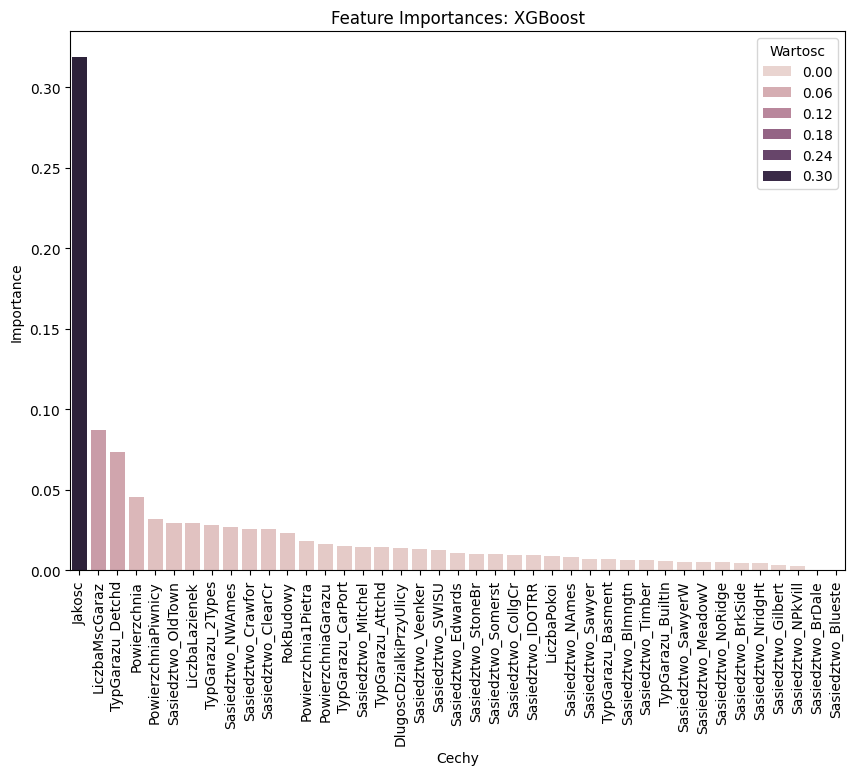

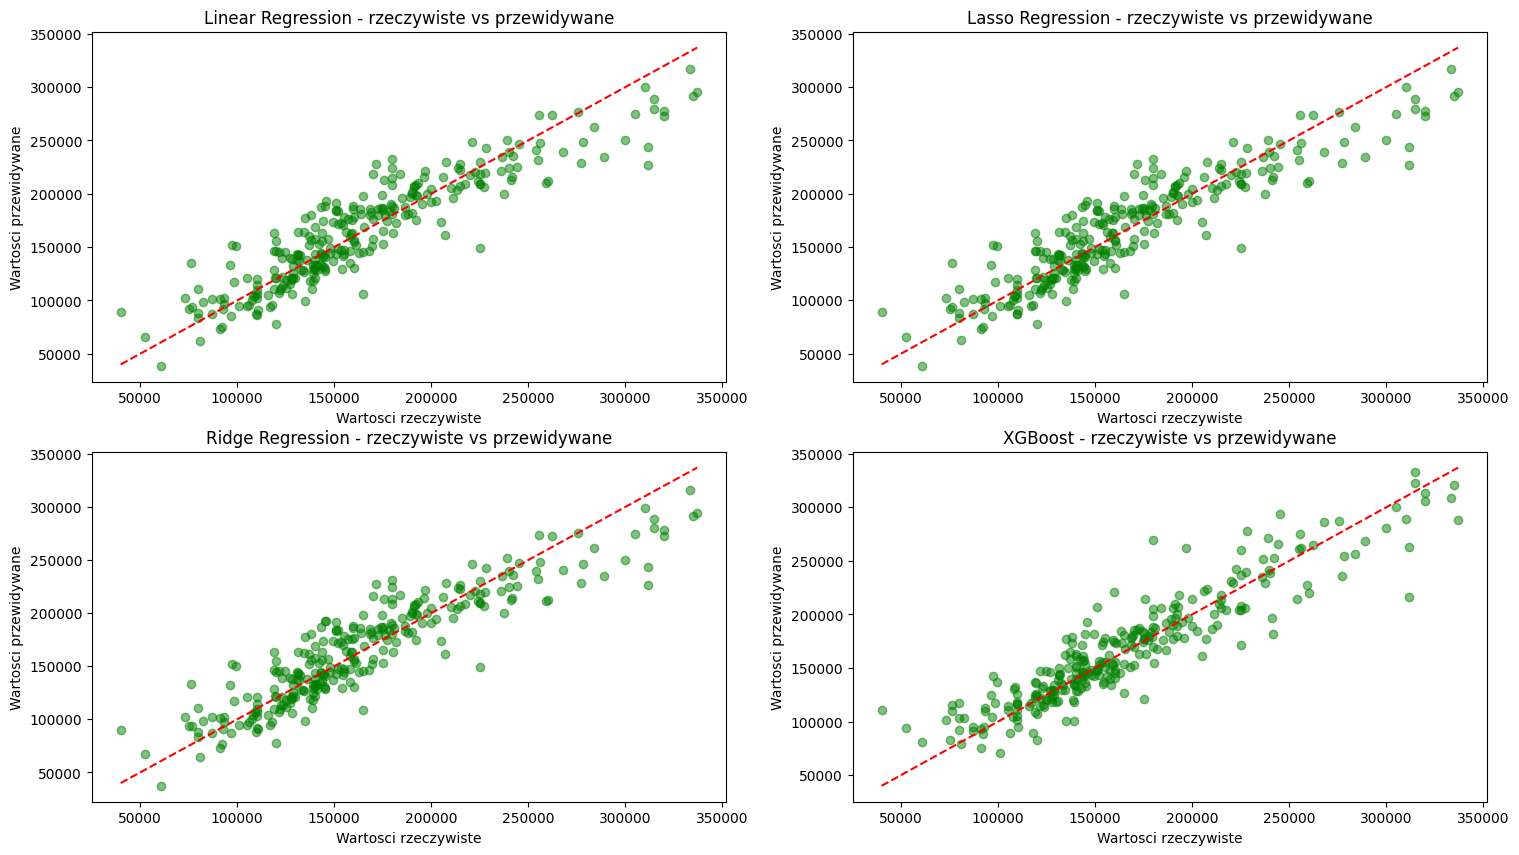

In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

houses = pd.read_csv("houses.csv")

num_features = houses.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = houses.select_dtypes(include=['object']).columns.tolist()

num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

houses[num_features] = num_imputer.fit_transform(houses[num_features])
houses[cat_features] = cat_imputer.fit_transform(houses[cat_features])

Q1 = houses['Cena'].quantile(0.25)
Q3 = houses['Cena'].quantile(0.75)

IQR = Q3-Q1

upper_bound = Q3 + IQR * 1.5
lower_bound = Q1 - IQR * 1.5

houses = houses[(houses['Cena'] >= lower_bound) & (houses['Cena'] <= upper_bound)]

encoder = OneHotEncoder(sparse_output=False, handle_unknown = 'ignore')
encoded = encoder.fit_transform(houses[cat_features])
encoded = pd.DataFrame(encoded)

encoded.index = houses.index
encoded.columns = encoder.get_feature_names_out(cat_features)

houses = houses.drop(columns = cat_features)
houses = houses.join(encoded)

from sklearn.model_selection import train_test_split

X = houses.drop(columns = ["Cena"])
y = houses['Cena']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

num_features.remove('Cena')

X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

from sklearn.linear_model import LinearRegression, Ridge, Lasso
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Lista modeli do przetestowania
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=1.0),
    "XGBoost": xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.8, random_state=42)
}

# Słowniki do przechowywania wyników
metrics = {"Model": [], "MAE": [], "RMSE": [], "R² Score": []}
predictions = {name: None for name in models}
coefficients = {name: None for name in models}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred

    metrics["Model"].append(name)
    metrics["MAE"].append(mean_absolute_error(y_test, y_pred))
    metrics["RMSE"].append(np.sqrt(mean_squared_error(y_test, y_pred)))
    metrics["R² Score"].append(r2_score(y_test, y_pred))

    if hasattr(model, 'coef_'):
        coefficients[name] = model.coef_

results_df = pd.DataFrame(metrics)
importances = models['XGBoost'].feature_importances_

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

importances_df = pd.DataFrame({
    "Kolumna": X_train.columns,
    "Wartosc": importances
})

importances_df = importances_df.sort_values(by="Wartosc", ascending=False)

os_x = range(len(importances_df))
os_y = importances_df["Wartosc"]

plt.figure(figsize=(10, 7))
sns.barplot(x=os_x, y=os_y, hue=importances_df["Wartosc"])
plt.xticks(os_x, importances_df["Kolumna"], rotation=90)
plt.xlabel("Cechy")
plt.ylabel("Importance")
plt.title("Feature Importances: XGBoost")
plt.show()

def real_vs_predicted(ax, model_name, y_true, y_pred):
    ax.scatter(y_true, y_pred, color="green", alpha=0.5)
    ax.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
    ax.set_title(f"{model_name} - rzeczywiste vs przewidywane")
    ax.set_xlabel("Wartosci rzeczywiste")
    ax.set_ylabel("Wartosci przewidywane")

fig, axes = plt.subplots(2, 2, figsize=(18, 10))
real_vs_predicted(axes[0, 0], "Linear Regression", y_test, predictions["Linear Regression"])
real_vs_predicted(axes[1, 0], "Ridge Regression", y_test, predictions["Ridge Regression"])
real_vs_predicted(axes[0, 1], "Lasso Regression", y_test, predictions["Lasso Regression"])
real_vs_predicted(axes[1, 1], "XGBoost", y_test, predictions["XGBoost"])

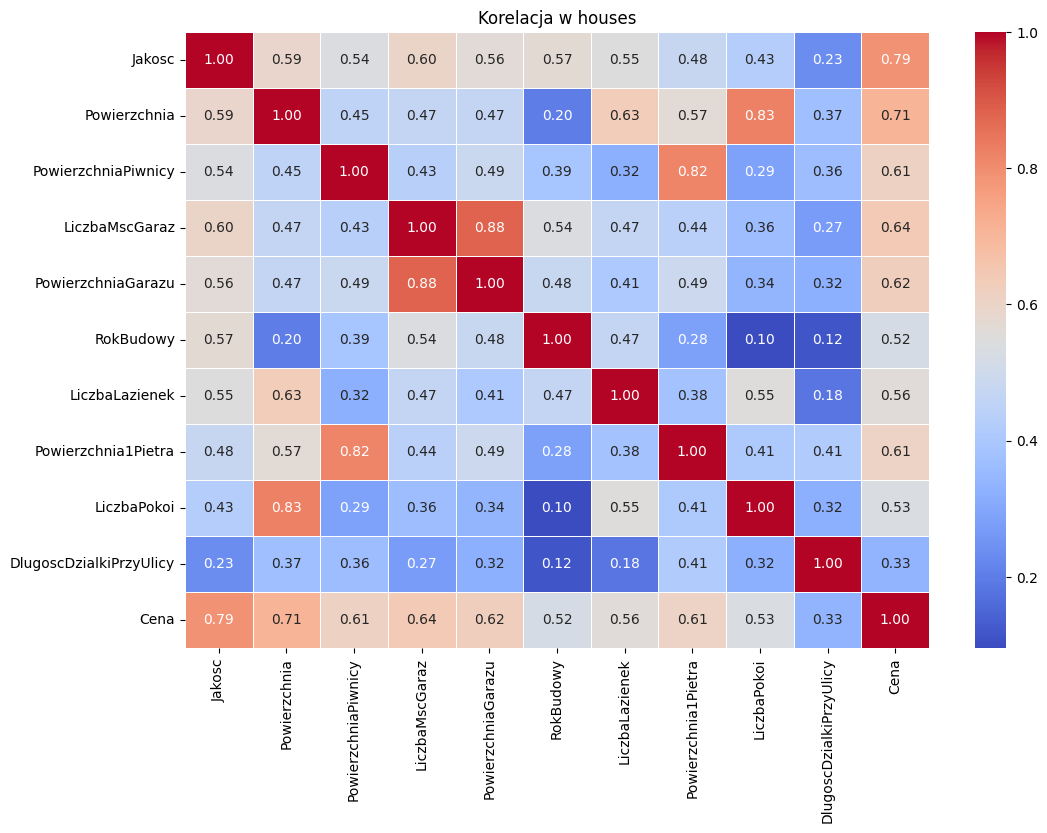

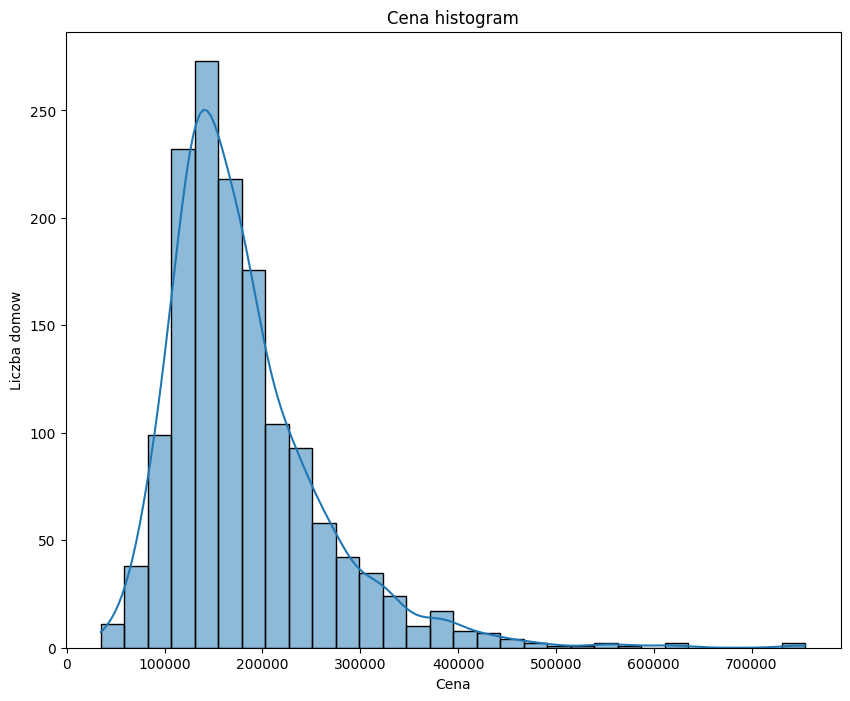

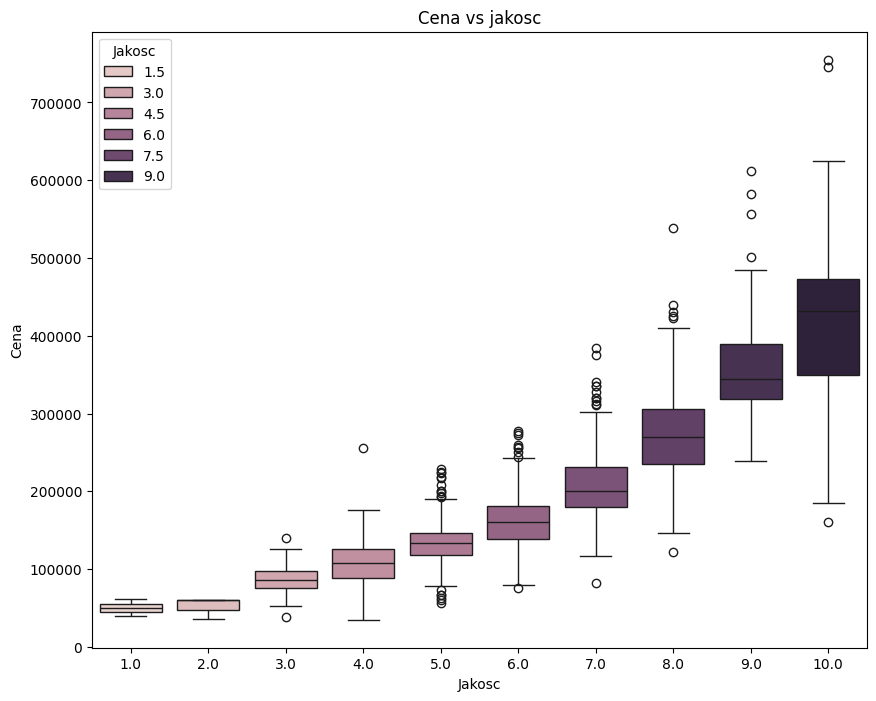

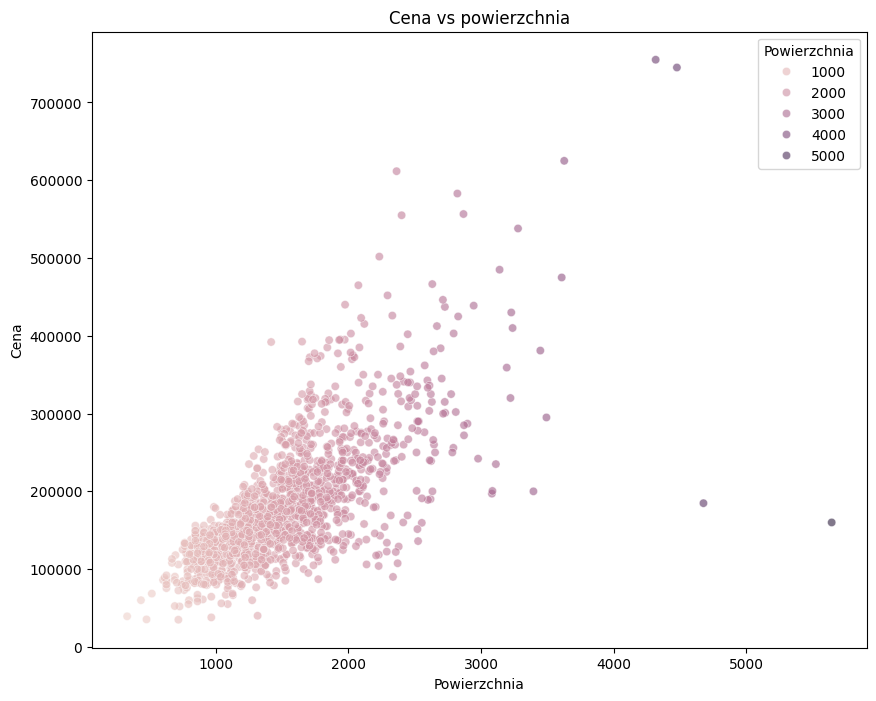

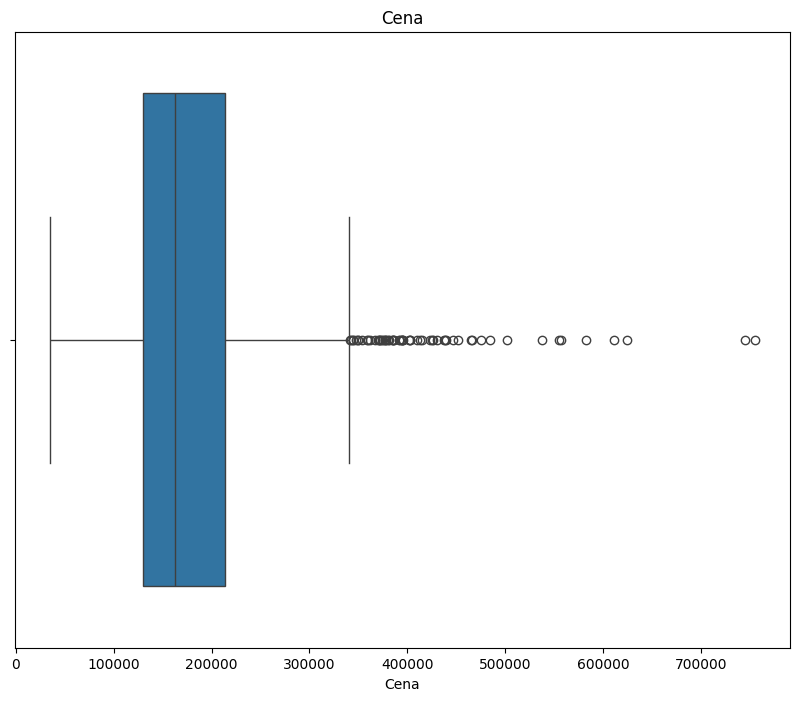

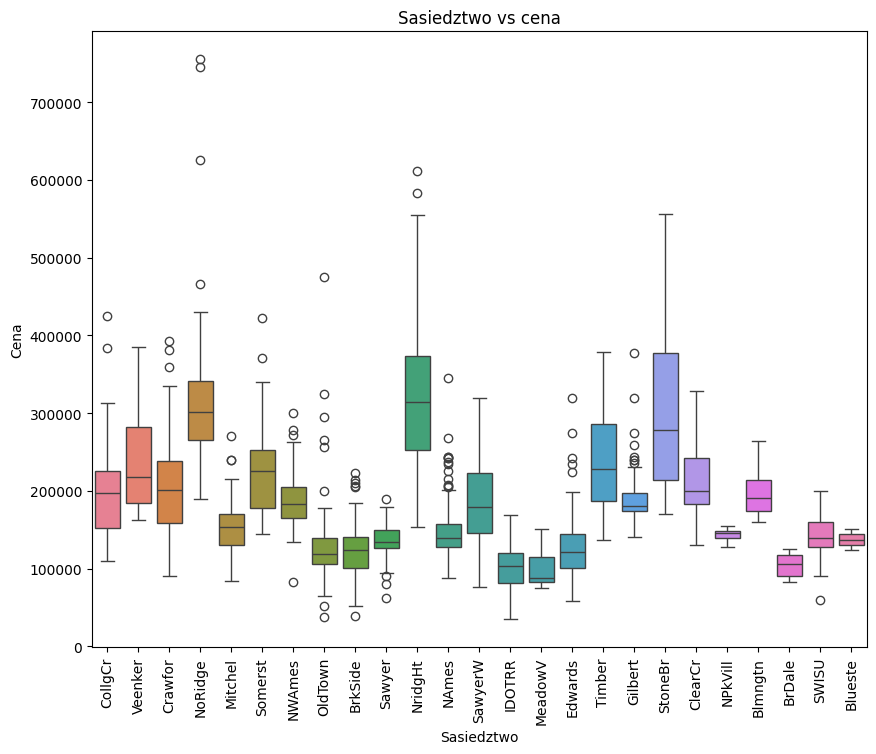

In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

houses = pd.read_csv("houses.csv")
num_features = houses.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = houses.select_dtypes(include=['object']).columns.tolist()

num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

houses[num_features] = num_imputer.fit_transform(houses[num_features])
houses[cat_features] = cat_imputer.fit_transform(houses[cat_features])

houses_corr = houses[num_features].corr()

plt.figure(figsize=[12, 8])
sns.heatmap(houses_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Korelacja w houses')
plt.show()

plt.figure(figsize=[10, 8])
sns.histplot(houses['Cena'], bins=30, kde=True)
plt.title('Cena histogram')
plt.xlabel('Cena')
plt.ylabel('Liczba domow')
plt.show()


plt.figure(figsize=[10, 8])
sns.boxplot(x=houses['Jakosc'], y=houses['Cena'], hue=houses['Jakosc'])
plt.title('Cena vs jakosc')
plt.xlabel('Jakosc')
plt.ylabel('Cena')
plt.show()

plt.figure(figsize=[10, 8])
sns.scatterplot(x=houses['Powierzchnia'], y=houses['Cena'], alpha=0.6, hue=houses['Powierzchnia'])
plt.title('Cena vs powierzchnia')
plt.xlabel('Powierzchnia')
plt.ylabel('Cena')
plt.show()

plt.figure(figsize=[10, 8])
sns.boxplot(x=houses['Cena'])
plt.title('Cena')
plt.xlabel('Cena')
plt.show()

plt.figure(figsize=[10, 8])
sns.boxplot(x=houses['Sasiedztwo'], y=houses['Cena'], hue=houses['Sasiedztwo'])
plt.title('Sasiedztwo vs cena')
plt.xlabel('Sasiedztwo')
plt.xticks(rotation=90)
plt.ylabel('Cena')
plt.show()

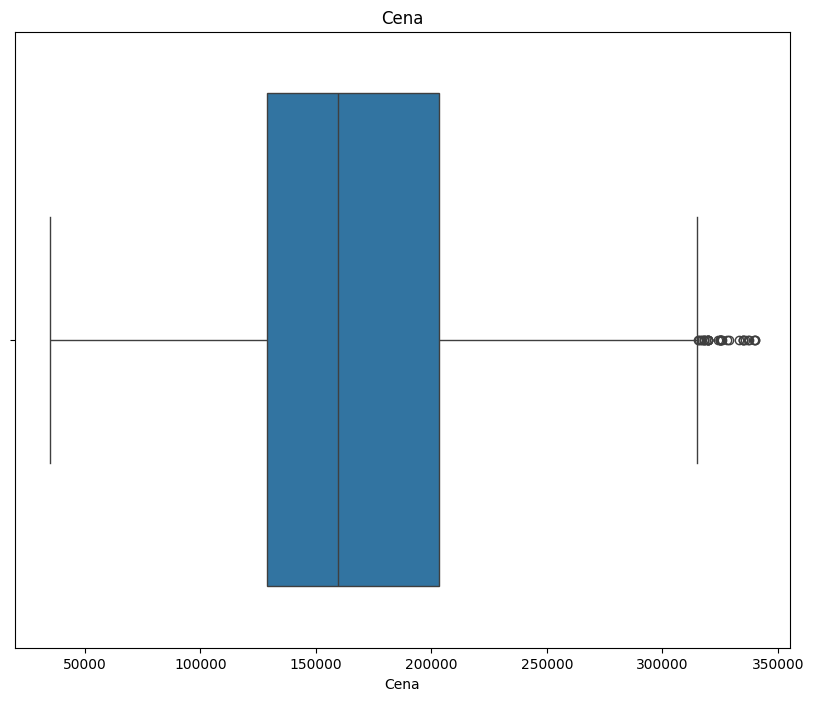

In [ ]:
Q1 = houses['Cena'].quantile(0.25)
Q3 = houses['Cena'].quantile(0.75)

IQR = Q3-Q1

upper_bound = Q3 + IQR * 1.5
lower_bound = Q1 - IQR * 1.5

houses = houses[(houses['Cena'] >= lower_bound) & (houses['Cena'] <= upper_bound)]

plt.figure(figsize=[10, 8])
sns.boxplot(x=houses['Cena'])
plt.title('Cena')
plt.xlabel('Cena')
plt.show()

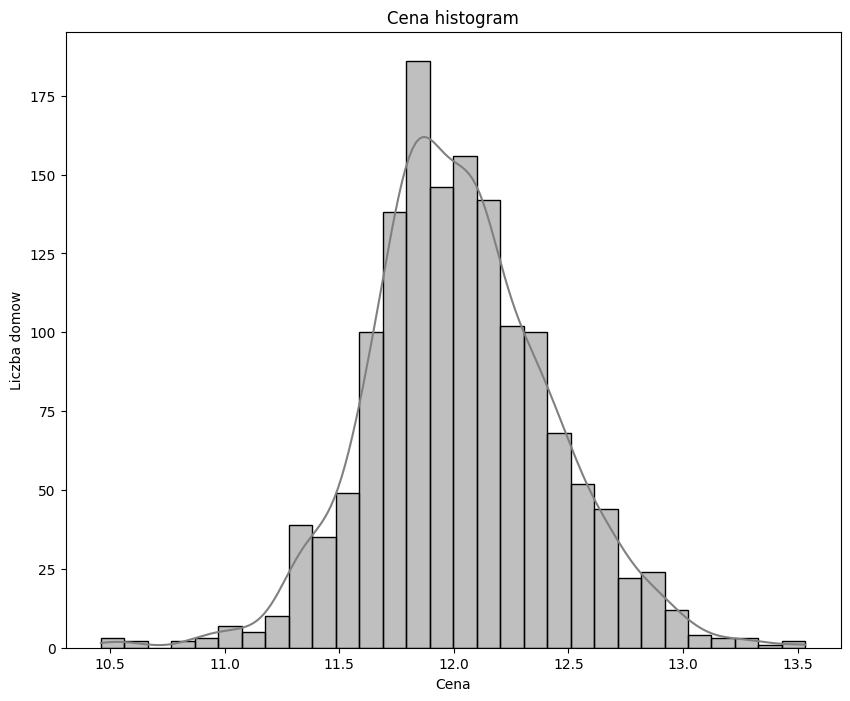

In [ ]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

houses = pd.read_csv("houses.csv")
num_features = houses.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = houses.select_dtypes(include=['object']).columns.tolist()

num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

houses[num_features] = num_imputer.fit_transform(houses[num_features])
houses[cat_features] = cat_imputer.fit_transform(houses[cat_features])

houses['Cena'] = np.log(houses['Cena'])

plt.figure(figsize=[10, 8])
sns.histplot(houses['Cena'], bins=30, kde=True, color='grey')
plt.title('Cena histogram')
plt.xlabel('Cena')
plt.ylabel('Liczba domow')
plt.show()